Python Setup

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml #using openml to import data
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer #transform different types

Data: The target variable `y` indicates whether passengers survived the Titanic disaster


In [38]:
X_initial, y = fetch_openml("titanic", version=1, as_frame=True)
combine_dataset = pd.concat ([X_initial, y], axis=1)
features = ['age', 'fare', 'embarked', 'sex', 'pclass']
X = X_initial[features].copy()
X.head()

,age,fare,embarked,sex,pclass
0,29.0000,211.3375,S,female,1
1,0.9167,151.5500,S,male,1
2,2.0000,151.5500,S,female,1
3,30.0000,151.5500,S,male,1
4,25.0000,151.5500,S,female,1


Numerical features: applying `Simpleimputer` and `StandardScaler` into a pipeline

In [7]:
numerical_features = ['age', 'fare']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

Categorical features: applying `Simpleimputer` and `OneHotEncoder` into another pipeline

In [9]:
categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('encoder', OneHotEncoder())
])

Put everything together into the preprocessor pipeline

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Split the data into train and training samples

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_initial, y, test_size=0.5, random_state=1)

Parameter grid for `GridSearchCV` k-fold Cross Validation

In [15]:
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__cat__imputer__strategy': ['constant', 'most_frequent']
}

Logistic Regression Pipeline

In [17]:
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('logistic', LogisticRegression(max_iter=10000))])

grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid, cv=5)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['embarked',
                                                                          'sex',
                                                                          'pclass'])])),
                                       ('logistic',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'preprocessor__cat__imputer__strategy': ['constant',
                                                                  'most_frequent'],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']})

Gradient Bossting Pipeline

In [19]:
pipe_gdb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('gradient_boosting', GradientBoostingClassifier(random_state=2))])

grid_gdb = GridSearchCV(pipe_gdb, param_grid=param_grid, cv=5)
grid_gdb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['embarked',
                                                                          'sex',
                                                                          'pclass'])])),
                                       ('gradient_boosting',
                                        GradientBoostingClassifier(random_state=2))]),
             param_grid={'preprocessor__cat__imputer__strategy': ['constant',
                                                                  'most_frequent'],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']})

Compare the two pipelines in terms of the ROC plot

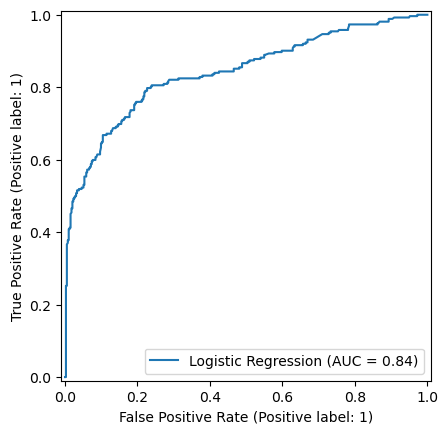

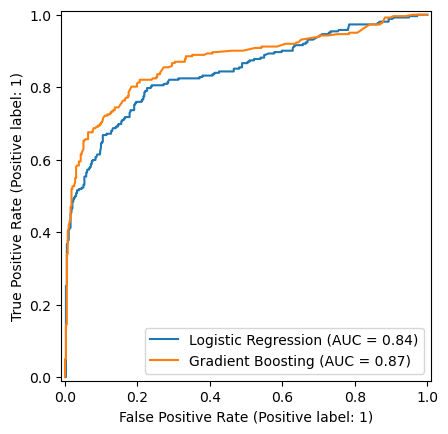

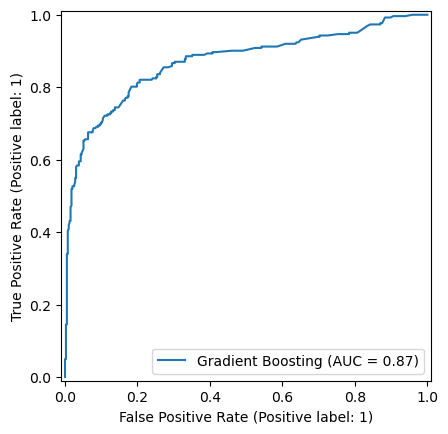

In [21]:
# Generate the ROC display for Logistic Regression
roc_display_lr = RocCurveDisplay.from_estimator(grid_lr.best_estimator_, X_test, y_test, name='Logistic Regression')
roc_display_lr.plot()

# Generate the ROC display for Gradient Boosting on the same axes
roc_display_gdb = RocCurveDisplay.from_estimator(grid_gdb.best_estimator_, X_test, y_test, name='Gradient Boosting')
roc_display_gdb.plot(ax=roc_display_lr.ax_)  # Use the same axis as the first plot

plt.show()


### ROC Curve Interpretation for Titanic Dataset by ChatGPT

The ROC curves for two models—Logistic Regression (LR) and Gradient Boosting (GB)—are plotted with the following observations:

- **AUC Scores**: LR (AUC = 0.84) slightly lags behind GB (AUC = 0.87).
    - GB's higher AUC indicates a superior ability to differentiate between survivors and non-survivors based on the selected features.
  
- **Predictive Performance**:
    - Both models show competence, but GB shows a slightly better true positive rate across various false positive rate thresholds.
    - The selected features—numerical (`age`, `fare`) standardized and categorical (`embarked`, `sex`, `pclass`) one-hot encoded—provide good predictive power for both models.

- **Practical Consideration**:
    - Despite GB's higher AUC, the decision to deploy a model should consider other metrics like precision, recall, and real-world implications of false predictions.
    - Model interpretability and operational costs are also important factors, especially for safety-critical applications like predicting Titanic survivors.

In essence, with the given features, GB might be preferred for its accuracy, but the choice must be aligned with the broader context of the use case.